# Basic Implementation of an Inventory Model

**Basic Description**: Consider a store that stocks a particular type of product sold at a price of $R$ per unit. Customers demanding this product arrive following a Poisson process with rate $\lambda$, and the quantity demanded by each customer is a random variable with distribution $G$. To meet the demands, the storekeeper must maintain an available product quantity, and whenever the available inventory is less than $s$ and there is no pending order, an order is placed to replenish it up to $S$, where $s < S$. That is, if the current inventory level is $x$ and there is no pending order, then if $x < s$, an order for the amount $S - x$ is placed. The cost of ordering $y$ units of the product is a specified function $c(y)$, and the time until the order is delivered is $L$; payment is made upon receipt of the order. If a customer demands more product than is available, the quantity on hand is sold, and the remainder of the order is lost to the store.

**Components**: Inventory System Simulation with (s,S) policy.
- *System State*: 
  - `current_inventory`: current available inventory level
  - `pending_order`: status of pending order (if there's an order in transit)
  - `current_time`: current simulation time
  - Cumulative variables: `total_revenue`, `total_cost`, `total_lost_sales`, `customers_served`, `orders_placed`
- *Time Variables*:
  - `current_time`: Main variable tracking elapsed simulation time
  - Counter variables: `customers_served` (counts served customers), `orders_placed` (counts placed orders), `total_lost_sales` (counts lost sales)
- *Event Sequence*: 
  - `event_queue`: Priority queue (heap) that organizes events by occurrence time
  - Scheduled event types: `customer_arrival` (customer arrivals), `order_delivery` (replenishment order deliveries)
- *Entities*: 
  - `Customer` (temporal entities): Customers who arrive at the system with specific demand and then leave
  - `Order` (temporal entities): Replenishment orders that are created, transit during lead time, and get delivered
  - `InventorySystem` (permanent entities): The inventory system that persists throughout the entire simulation, changing state but remaining active
- *Resources*: 
  - `current_inventory` (consumable resources): Product stock that is physically consumed when customers make purchases and replenished through replenishment orders

In [9]:
import heapq
import numpy as np 
import matplotlib.pyplot as plt 
from typing import Dict, List, Callable, Optional
from dataclasses import dataclass
from scipy import stats 

np.random.seed(42)

@dataclass
class Customer:
  "Represents a customer with arrival time and demand"
  arrival_time:int
  demand:int 

@dataclass
class Order:
  "Represents a replenishment order"
  order_time:int
  delivery_time:int 
  quantity:int 
  cost:float 

@dataclass
class Event:
  "Generic event for discrete-event simulation"
  time:int 
  event_type:str 
  data:Dict
  
  def __lt__ (self, other:"Event") -> bool:
    return self.time < other.time 

@dataclass
class InventoryInfo:
  "Inventory state information over time"
  time:int
  quantity:int

class InventorySystem:
  "Inventory system with (s,S) policy"
  def __init__(self,
      s:int,                                  # inventory threshold for new order
      S:int,                                  # maximum inventory level
      R:float,                                # selling price per unit
      lambda_rate:float,                      # customer arrival rate
      demand_dist:stats.rv_continuous,        # demand distribution
      cost_function:Callable[[int], float],   # cost function c(y)
      lead_time:int, initial_inventory:int=0    
    ) -> None:
    # validate parameters
    if s >= S:
      raise ValueError("s must be less than S")
    if lambda_rate <= 0:
      raise ValueError("lambda rate must be positive")
    if R <= 0:
      raise ValueError("price R must be positive")
    if lead_time < 0:
      raise ValueError("lead time must be non-negative")
    
    self.s:int = s 
    self.S:int = S
    self.R:float = R 
    self.lambda_rate:float = lambda_rate
    self.demand_dist:stats.rv_continuous = demand_dist
    self.cost_function:Callable[[int], float] = cost_function
    self.lead_time:int = lead_time
    
    # system state
    self.current_inventory:int = initial_inventory
    self.pending_order:Optional[Order] = None
    self.current_time:int = 0
    
    # event queue (heap)
    self.event_queue:List[Event] = []
    
    # system statistics
    self.total_revenue:float = 0.0
    self.total_cost:float = 0.0
    self.total_lost_sales:int = 0
    self.customers_served:int = 0
    self.orders_placed:int = 0
    
    # history for analysis
    initial_info:InventoryInfo = InventoryInfo(
      time=0, 
      quantity=initial_inventory
    )
    self.inventory_history:List[InventoryInfo] = [initial_info]
    self.customer_history:List[Customer] = []
    self.order_history:List[Order] = []
  
  def schedule_event(self, event:Event) -> None:
    "Schedule an event in the event queue"
    heapq.heappush(self.event_queue, event)
  
  def generate_customer_arrivals(self, simulation_time:int) -> None:
    "Generate customer arrivals following a Poisson process"
    current_time = 0
    
    while current_time < simulation_time:
      # time between arrivals (exponential, rounded to integer)
      inter_arrival_time = max(1, int(np.round(np.random.exponential(1.0 / self.lambda_rate))))
      current_time += inter_arrival_time
      
      if current_time < simulation_time:
        # generate customer demand
        demand = max(1, int(self.demand_dist.rvs()))
        
        # create customer arrival event
        customer_event = Event(
          time=current_time,
          event_type="customer_arrival",
          data={"demand":demand}
        )
        self.schedule_event(customer_event)
  
  def process_customer_arrival(self, arrival_time:int, demand:int) -> None:
    "Process customer arrival"
    self.current_time = arrival_time 
    
    # create customer record
    customer = Customer(arrival_time=arrival_time, demand=demand)
    self.customer_history.append(customer)
    
    # determine how much can be sold
    units_sold = min(demand, self.current_inventory)
    lost_sales = demand - units_sold
    
    # update inventory and statistics
    self.current_inventory -= units_sold
    self.total_revenue += units_sold * self.R 
    self.total_lost_sales += lost_sales
    if units_sold > 0:
      self.customers_served += 1
    
    # record inventory change
    self.inventory_history.append(InventoryInfo(arrival_time, self.current_inventory))
    
    # check if reorder is needed
    self.check_reorder_policy()
    
  def check_reorder_policy(self) -> None:
    "Check the (s,S) reorder policy"
    if self.current_inventory < self.s and self.pending_order is None:
      # calculate order quantity
      order_quantity = self.S - self.current_inventory
      order_cost = self.cost_function(order_quantity)

      # create order
      delivery_time = self.current_time + self.lead_time
      order = Order(
        order_time=self.current_time,
        delivery_time=delivery_time,
        quantity=order_quantity,
        cost=order_cost
      )
      
      self.pending_order = order 
      self.order_history.append(order)
      self.orders_placed += 1
      
      # schedule delivery event
      delivery_event = Event(
        time=delivery_time,
        event_type="order_delivery",
        data={"order":order}
      )
      self.schedule_event(delivery_event)
  
  def process_order_delivery(self, delivery_time:int, order:Order) -> None:
    "Process order delivery"
    self.current_time = delivery_time
    
    # update inventory
    self.current_inventory += order.quantity
    self.total_cost += order.cost
    
    # clear pending order
    self.pending_order = None
    
    # record inventory change
    self.inventory_history.append(InventoryInfo(delivery_time, self.current_inventory))
    
  def simulate(self, simulation_time:int) -> None:
    "Run the simulation over a specified period"
    print(f"Starting simulation for {simulation_time} time units")
    print(f"Parameters: s={self.s}, S={self.S}, R=${self.R}, lambda={self.lambda_rate}, L={self.lead_time}")
    print(f"Initial inventory: {self.current_inventory}")
    
    # generate customer arrivals
    self.generate_customer_arrivals(simulation_time)
    
    # if initial inventory requires reorder
    if self.current_inventory < self.s:
      self.check_reorder_policy()
    
    # process events
    while self.event_queue and self.event_queue[0].time <= simulation_time:
      event = heapq.heappop(self.event_queue)
      match event.event_type:
        case "customer_arrival":
          self.process_customer_arrival(event.time, event.data["demand"])
        case "order_delivery":
          self.process_order_delivery(event.time, event.data["order"])
    
    # update final time
    self.current_time = simulation_time
  
  def get_statistics(self) -> dict:
    "Calculate and return simulation statistics"
    total_customers = len(self.customer_history)
    total_demand = sum(c.demand for c in self.customer_history)
    service_level = self.customers_served / total_customers if total_customers > 0 else 0
    fill_rate = (total_demand - self.total_lost_sales) / total_demand if total_demand > 0 else 0
    net_profit = self.total_revenue - self.total_cost
    
    stats = {
      "simulation_time": self.current_time,
      "total_customers": total_customers,
      "customers_served": self.customers_served,
      "service_level": service_level,
      "total_demand": total_demand,
      "total_lost_sales": self.total_lost_sales,
      "fill_rate": fill_rate,
      "total_revenue": self.total_revenue,
      "total_cost": self.total_cost,
      "net_profit": net_profit,
      "orders_placed": self.orders_placed,
      "final_inventory": self.current_inventory
    }
    
    return stats
  
  def print_statistics(self) -> None:
    "Show simulation statistics"
    stats = self.get_statistics()
    
    print("=====================")
    print("SIMULATION STATISTICS")
    print("=====================")
    print(f"Simulation time: {stats['simulation_time']}")
    print(f"Total customers: {stats['total_customers']}")
    print(f"Customers served: {stats['customers_served']}")
    print(f"Service level: {stats['service_level']:.2%}")
    print(f"Total demand: {stats['total_demand']}")
    print(f"Lost sales: {stats['total_lost_sales']}")
    print(f"Fill rate: {stats['fill_rate']:.2%}")
    print(f"Total revenue: ${stats['total_revenue']:.2f}")
    print(f"Total costs: ${stats['total_cost']:.2f}")
    print(f"Net profit: ${stats['net_profit']:.2f}")
    print(f"Orders placed: {stats['orders_placed']}")
    print(f"Ending inventory: {stats['final_inventory']}")

  
  def plot_inventory_evolution(self) -> None:
    times, inventories = zip(*[(state.time, state.quantity) for state in self.inventory_history])

    plt.figure(figsize=(12, 6))
    plt.step(times, inventories, where='post', linewidth=2, label='Inventory')
    plt.axhline(y=self.s, color='red', linestyle='--', alpha=0.7, label=f'Reorder point (s={self.s})')
    plt.axhline(y=self.S, color='green', linestyle='--', alpha=0.7, label=f'Maximum level (S={self.S})')

    plt.xlabel('Time')
    plt.ylabel('Inventory Level')
    plt.title('Inventory Evolution Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Below is an example using a simple linear function as a cost function, and as a demand distribution, a normal distribution is used

Starting simulation for 50 time units
Parameters: s=10, S=30, R=$5.0, lambda=2.0, L=3
Initial inventory: 25
SIMULATION STATISTICS
Simulation time: 50
Total customers: 48
Customers served: 48
Service level: 100.00%
Total demand: 117
Lost sales: 0
Fill rate: 100.00%
Total revenue: $585.00
Total costs: $472.00
Net profit: $113.00
Orders placed: 5
Ending inventory: 19


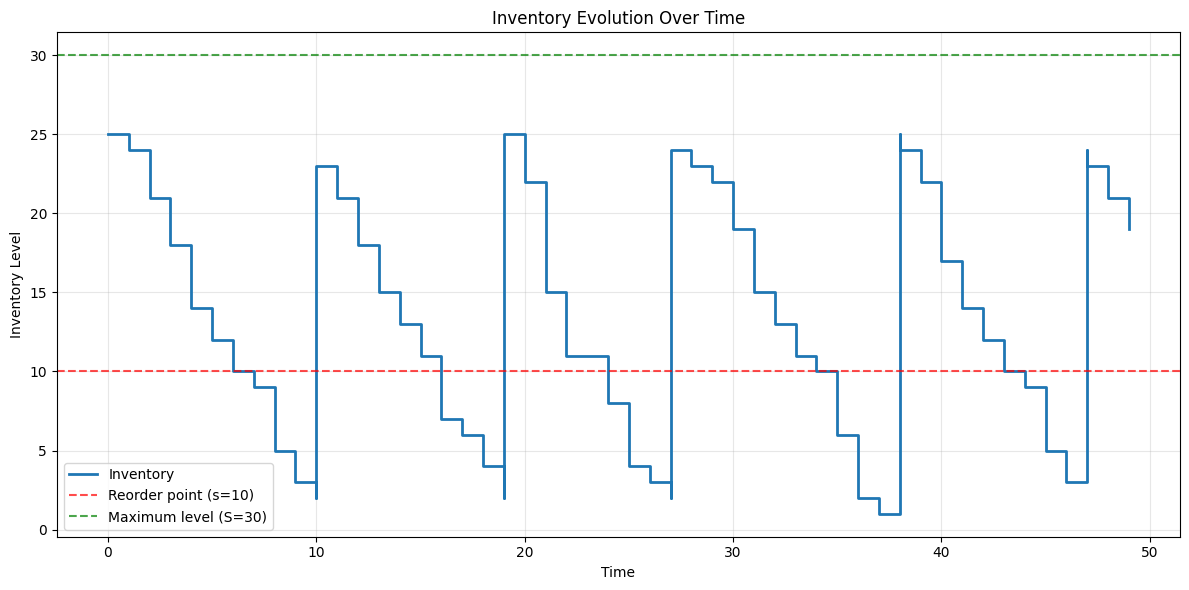

In [10]:
def linear_cost_function(quantity:int) -> float:
  "Linear cost function: fixed cost + variable cost per unit"
  fixed_cost = 50.0   # fixed cost per order
  variable_cost = 2.0 # cost per unit
  return fixed_cost + variable_cost * quantity

# demand distribution (normal truncated at 1)
demand_dist = stats.norm(loc=3, scale=1.5)  # mean=3, standard deviation=1.5

# create and run simulation
system = InventorySystem(
  s=10, S=30, R=5.0,
  lambda_rate=2.0,
  demand_dist=demand_dist,
  cost_function=linear_cost_function,
  lead_time=3, initial_inventory=25
)
system.simulate(50)

system.print_statistics()
system.plot_inventory_evolution()